In [1]:
from __future__ import print_function, division

import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from collections import defaultdict
from model import SiameseNetwork
from loss import TripletLoss
from dataset import WordAudioDataset
from data_prep import prepare_seen_unseen_data
from transforms import get_transforms
from model_handler import ModelHandler

from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

/home/audio_dev/anaconda3/envs/jc_audio_dl/lib/python3.7/site-packages/requests/__init__.py:114: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (5.0.0)/charset_normalizer (2.0.6) doesn't match a supported version!
  RequestsDependencyWarning,


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

(
    seen_word_classes,
    seen_audio_X_train, 
    seen_audio_y_train, 
    seen_audio_X_test, 
    seen_audio_y_test,
    unseen_word_classes,
    unseen_audio_X_train, 
    unseen_audio_y_train, 
    unseen_audio_X_test, 
    unseen_audio_y_test,
    inst_word_emb_dict
) = prepare_seen_unseen_data()

In [3]:
seen_word_classes

['bassoon', 'cello', 'flute', 'oboe', 'trumpet', 'tuba', 'violin']

In [4]:
unseen_word_classes

['accordion',
 'clarinet',
 'contrabass',
 'horn',
 'saxophone',
 'trombone',
 'viola']

In [5]:
siamese_network = SiameseNetwork()
triplet_loss = TripletLoss(0.5)
siamese_network.to(device)
triplet_loss.to(device)

TripletLoss(
  (relu): ReLU()
)

In [6]:
mel_transform = get_transforms()

In [7]:
seen_word_audio_dataset_tr = WordAudioDataset(
    audio_path_list = seen_audio_X_train,
    audio_label_list = seen_audio_y_train,
    audio_transform = mel_transform,
    curr_word_classes = seen_word_classes,
    word_emb_dict = inst_word_emb_dict
)
seen_word_audio_dataset_ts = WordAudioDataset(
    audio_path_list = seen_audio_X_test,
    audio_label_list = seen_audio_y_test,
    audio_transform = mel_transform,
    curr_word_classes = seen_word_classes,
    word_emb_dict = inst_word_emb_dict
)

In [8]:
seen_word_audio_dataloaders = {}
seen_word_audio_dataloaders['train'] = DataLoader(
    seen_word_audio_dataset_tr,
    batch_size=16, 
    num_workers=8,
    shuffle=True
)
seen_word_audio_dataloaders['test'] = DataLoader(
    seen_word_audio_dataset_ts,
    batch_size=16, 
    num_workers=8,
    shuffle=True
)

In [9]:
optimizer_siamese = optim.Adam(siamese_network.parameters(), lr=0.01)
exp_lr_scheduler = ReduceLROnPlateau(
    optimizer_siamese, 
    mode='min', 
    factor=0.2, 
    patience=5, 
    verbose=True
)

In [10]:
curr_model = ModelHandler(
    siamese_network, 
    triplet_loss, 
    optimizer_siamese, 
    exp_lr_scheduler, 
    device
)

In [11]:
curr_model.load_model('./checkpoints/word_audio_baseline_221127/w_ep-00195_l-0.0017.pth')

Loading model done: ./checkpoints/word_audio_baseline_221127/w_ep-00195_l-0.0017.pth


In [19]:
(
    seen_tr_audio_embs, 
    seen_tr_word_embs, 
    seen_tr_labels, 
    seen_tr_loss,
    org_seen_tr_word_embs
) = curr_model.infer(seen_word_audio_dataloaders['train'].dataset)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 904/904 [00:42<00:00, 21.07it/s]

Test Loss: 0.0010


In [12]:
(
    seen_ts_audio_embs, 
    seen_ts_word_embs, 
    seen_ts_labels, 
    seen_ts_loss,
    org_seen_ts_word_embs
) = curr_model.infer(seen_word_audio_dataloaders['test'].dataset)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [00:10<00:00, 21.10it/s]

Test Loss: 0.0046


In [13]:
for i in range(len(seen_ts_labels)-1):
    if not (seen_ts_labels[i] == seen_ts_labels[i+1]):
        print(i)

25
84
106
129
149
169


In [14]:
for i in range(len(org_seen_ts_word_embs)-1):
    if not (org_seen_ts_word_embs[i] == org_seen_ts_word_embs[i+1]).all():
        print(i)

25
84
106
129
149
169


In [15]:
for i in range(seen_ts_word_embs.shape[0]-1):
    if not (seen_ts_word_embs[i] == seen_ts_word_embs[i+1]).all():
        print(i)

25
84
106
129
149
169


In [26]:
seen_class_to_audio_embs, seen_class_to_word_embs = defaultdict(list), defaultdict(list)
for i in tqdm(range(seen_tr_audio_embs.shape[0])):
    seen_class_to_audio_embs[seen_tr_labels[i]].append(seen_tr_audio_embs[i])
    seen_class_to_word_embs[seen_tr_labels[i]].append(seen_tr_word_embs[i])

for i in range(len(list(seen_class_to_audio_embs.keys()))):
    print(i, len(seen_class_to_audio_embs[i]), len(seen_class_to_word_embs[i]))    
    
seen_class_to_mean_audio_emb, seen_class_to_mean_word_emb = {}, {}
for _c in seen_class_to_audio_embs:
    seen_class_to_mean_audio_emb[_c] = np.mean(seen_class_to_audio_embs[_c], axis=0)
    seen_class_to_mean_word_emb[_c] = seen_class_to_word_embs[_c][0] # same embeddings

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 904/904 [00:00<00:00, 309270.05it/s]

0 100 100
1 232 232
2 96 96
3 84 84
4 76 76
5 88 88
6 228 228


In [21]:
seen_class_txt_list = seen_word_audio_dataset_ts.word_classes

In [22]:
seen_class_txt_list

['bassoon', 'cello', 'flute', 'oboe', 'trumpet', 'tuba', 'violin']

In [17]:
seen_class_to_mean_word_emb[0].shape

(128,)

In [29]:
def nearest_neighbor_clf(query_emb, class_to_mean_emb, class_txt_list):
    class_embs = []
    for i in range(len(class_txt_list)):
        class_embs.append(class_to_mean_emb[i])
    class_embs = np.stack(class_embs, 0)
    sim_matrix = cosine_similarity(query_emb, class_embs)
    df_sim = pd.DataFrame(sim_matrix).T
    top_idx = df_sim[0].sort_values(ascending=False).head(5)
    return top_idx.index[0], class_txt_list[top_idx.index[0]]

In [30]:
def nearest_neighbor_clf_k(query_emb, class_to_mean_emb, class_txt_list, k=5):
    class_embs = []
    for i in range(len(class_txt_list)):
        class_embs.append(class_to_mean_emb[i])
    class_embs = np.stack(class_embs, 0)
    sim_matrix = cosine_similarity(query_emb, class_embs)
    df_sim = pd.DataFrame(sim_matrix).T
    top_idx = df_sim[0].sort_values(ascending=False).head(k)
    return top_idx.index, [class_txt_list[top_idx.index[i]] for i in range(k)]

### 1-1. Test set audio to seen word class prediction (supervised learning evaluation)

In [31]:
correct = 0
for idx in range(seen_ts_audio_embs.shape[0]):
    curr_pred_idx, _ = nearest_neighbor_clf(np.expand_dims(seen_ts_audio_embs[idx], 0), 
                                            seen_class_to_mean_word_emb, 
                                            seen_class_txt_list)
    if curr_pred_idx == seen_ts_labels[idx]:
        correct += 1
print('Top-1 acc :', correct / seen_ts_audio_embs.shape[0])

Top-1 acc : 0.9867256637168141


In [32]:
correct = 0
for idx in range(seen_ts_audio_embs.shape[0]):
    curr_pred_indices, _ = nearest_neighbor_clf_k(np.expand_dims(seen_ts_audio_embs[idx], 0), 
                                            seen_class_to_mean_word_emb, 
                                            seen_class_txt_list,
                                            3)
    if seen_ts_labels[idx] in curr_pred_indices:
        correct += 1
print('Top-3 acc :', correct / seen_ts_audio_embs.shape[0])

Top-3 acc : 0.995575221238938


### 1-2. Test set word to seen audio class prediction (supervised learning evaluation)

In [33]:
correct = 0
for idx in range(seen_ts_word_embs.shape[0]):
    curr_pred_idx, _ = nearest_neighbor_clf(np.expand_dims(seen_ts_word_embs[idx], 0), 
                                            seen_class_to_mean_audio_emb, 
                                            seen_class_txt_list)
    if curr_pred_idx == seen_ts_labels[idx]:
        correct += 1
print('Top-1 acc :', correct / seen_ts_word_embs.shape[0])

Top-1 acc : 1.0


In [72]:
def draw_tsne(_embs, _labels, _class_txt_list, dist='cosine'):
    tsne = TSNE(2, perplexity=10, n_iter=10000, verbose=0, metric=dist)
    _tsne_proj = tsne.fit_transform(_embs)
    cmap = cm.get_cmap('tab20')
    fig, ax = plt.subplots(figsize=(8,8))
    for _i in range(len(_class_txt_list)):
        indices = [_j for _j in range(len(_labels)) if _labels[_j] == _i]
        ax.scatter(_tsne_proj[indices, 0],
                   _tsne_proj[indices, 1], 
                   c=np.array(cmap(_i)).reshape(1,4), 
                   label=_class_txt_list[_i],
                   alpha=0.9
                  )
    ax.legend(fontsize='large', markerscale=2)
    plt.show()
    

In [79]:
def draw_pca(_embs, _labels, _class_txt_list):
    # tsne = TSNE(2, perplexity=10, n_iter=10000, verbose=0, metric=dist)
    pca = PCA(n_components=2)
    _pca_proj = pca.fit_transform(_embs)
    cmap = cm.get_cmap('tab20')
    fig, ax = plt.subplots(figsize=(8,8))
    for _i in range(len(_class_txt_list)):
        indices = [_j for _j in range(len(_labels)) if _labels[_j] == _i]
        ax.scatter(_pca_proj[indices, 0],
                   _pca_proj[indices, 1], 
                   c=np.array(cmap(_i)).reshape(1,4), 
                   label=_class_txt_list[_i],
                   alpha=0.9
                  )
    ax.legend(fontsize='large', markerscale=2)
    plt.show()
    

In [34]:
def draw_tsne(_embs, _labels, _class_txt_list, dist='cosine'):
    tsne = TSNE(2, perplexity=10, n_iter=10000, verbose=0, metric=dist)
    _tsne_proj = tsne.fit_transform(_embs)
    cmap = cm.get_cmap('tab20')
    fig, ax = plt.subplots(figsize=(8,8))
    for _i in range(len(_class_txt_list)):
        indices = [_j for _j in range(len(_labels)) if _labels[_j] == _i]
        ax.scatter(_tsne_proj[indices, 0],
                   _tsne_proj[indices, 1], 
                   c=np.array(cmap(_i)).reshape(1,4), 
                   label=_class_txt_list[_i],
                   s=12.0,
                   alpha=1.0
                  )
    ax.legend(fontsize='large', markerscale=3)
    plt.show()
    

In [35]:
def draw_pca(_embs, _labels, _class_txt_list):
    pca = PCA(n_components=2)
    _pca_proj = pca.fit_transform(_embs)
    cmap = cm.get_cmap('tab20')
    fig, ax = plt.subplots(figsize=(8,8))
    for _i in range(len(_class_txt_list)):
        indices = [_j for _j in range(len(_labels)) if _labels[_j] == _i]
        ax.scatter(_pca_proj[indices, 0],
                   _pca_proj[indices, 1], 
                   c=np.array(cmap(_i)).reshape(1,4), 
                   label=_class_txt_list[_i],
                   s=12.0,
                   alpha=1.0
                  )
    ax.legend(fontsize='large', markerscale=3)
    plt.show()
    

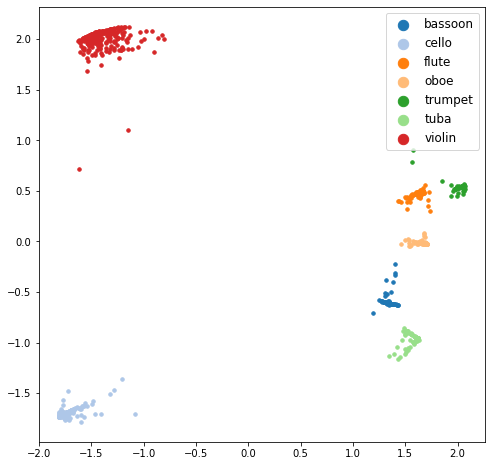

In [36]:
draw_pca(seen_tr_audio_embs, seen_tr_labels, seen_class_txt_list)

/home/audio_dev/anaconda3/envs/jc_audio_dl/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/audio_dev/anaconda3/envs/jc_audio_dl/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/audio_dev/anaconda3/envs/jc_audio_dl/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


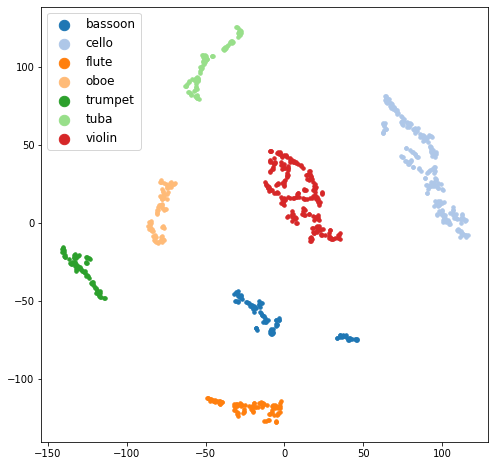

In [37]:
draw_tsne(seen_tr_audio_embs, seen_tr_labels, seen_class_txt_list, dist='cosine')

In [38]:
unseen_word_audio_dataset_tr = WordAudioDataset(
    audio_path_list = unseen_audio_X_train,
    audio_label_list = unseen_audio_y_train,
    audio_transform = mel_transform,
    curr_word_classes = unseen_word_classes,
    word_emb_dict = inst_word_emb_dict
)
unseen_word_audio_dataset_ts = WordAudioDataset(
    audio_path_list = unseen_audio_X_test,
    audio_label_list = unseen_audio_y_test,
    audio_transform = mel_transform,
    curr_word_classes = unseen_word_classes,
    word_emb_dict = inst_word_emb_dict
)

In [39]:
unseen_word_audio_dataloaders = {}
unseen_word_audio_dataloaders['train'] = DataLoader(
    unseen_word_audio_dataset_tr,
    batch_size=16, 
    num_workers=8,
    shuffle=True
)
unseen_word_audio_dataloaders['test'] = DataLoader(
    unseen_word_audio_dataset_ts,
    batch_size=16, 
    num_workers=8,
    shuffle=True
)

In [40]:
(
    unseen_tr_audio_embs, 
    unseen_tr_word_embs, 
    unseen_tr_labels, 
    unseen_tr_loss,
    org_unseen_tr_word_embs
) = curr_model.infer(unseen_word_audio_dataloaders['train'].dataset)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1426/1426 [01:07<00:00, 21.16it/s]

Test Loss: 0.3659


In [41]:
(
    unseen_ts_audio_embs, 
    unseen_ts_word_embs, 
    unseen_ts_labels, 
    unseen_ts_loss,
    org_unseen_ts_word_embs
) = curr_model.infer(unseen_word_audio_dataloaders['test'].dataset)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [00:17<00:00, 20.95it/s]

Test Loss: 0.3438


In [42]:
unseen_class_txt_list = unseen_word_audio_dataset_ts.word_classes

In [43]:
unseen_class_txt_list

['accordion',
 'clarinet',
 'contrabass',
 'horn',
 'saxophone',
 'trombone',
 'viola']

In [45]:
unseen_class_to_audio_embs, unseen_class_to_word_embs = defaultdict(list), defaultdict(list)
for i in tqdm(range(unseen_tr_audio_embs.shape[0])):
    unseen_class_to_audio_embs[unseen_tr_labels[i]].append(unseen_tr_audio_embs[i])
    unseen_class_to_word_embs[unseen_tr_labels[i]].append(unseen_tr_word_embs[i])

for i in range(len(list(unseen_class_to_audio_embs.keys()))):
    print(i, len(unseen_class_to_audio_embs[i]), len(unseen_class_to_word_embs[i]))    
    
unseen_class_to_mean_audio_emb, unseen_class_to_mean_word_emb = {}, {}
for _c in unseen_class_to_audio_embs:
    unseen_class_to_mean_audio_emb[_c] = np.mean(unseen_class_to_audio_embs[_c], axis=0)
    unseen_class_to_mean_word_emb[_c] = unseen_class_to_word_embs[_c][0]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1426/1426 [00:00<00:00, 547567.29it/s]

0 551 551
1 100 100
2 247 247
3 108 108
4 80 80
5 92 92
6 248 248


### 2-1. Unseen audio to unseen word class prediction (zero-shot evaluation)

In [46]:
correct = 0
for idx in range(unseen_ts_audio_embs.shape[0]):
    curr_pred_idx, _ = nearest_neighbor_clf(np.expand_dims(unseen_ts_audio_embs[idx], 0), 
                                            unseen_class_to_mean_word_emb, 
                                            unseen_class_txt_list)
    if curr_pred_idx == unseen_ts_labels[idx]:
        correct += 1
print('Top-1 acc :', correct / unseen_ts_audio_embs.shape[0])

Top-1 acc : 0.20168067226890757


In [50]:
correct = 0
for idx in range(unseen_ts_audio_embs.shape[0]):
    curr_pred_indices, _ = nearest_neighbor_clf_k(np.expand_dims(unseen_ts_audio_embs[idx], 0), 
                                            unseen_class_to_mean_word_emb, 
                                            unseen_class_txt_list,
                                            3)
    if unseen_ts_labels[idx] in curr_pred_indices:
        correct += 1
print('Top-3 acc :', correct / unseen_ts_audio_embs.shape[0])

Top-3 acc : 0.7450980392156863


### 2-2. Unseen word to unseen audio class prediction (zero-shot retrieval)

In [51]:
correct = 0
for idx in range(unseen_ts_word_embs.shape[0]):
    curr_pred_idx, _ = nearest_neighbor_clf(np.expand_dims(unseen_ts_word_embs[idx], 0), 
                                            unseen_class_to_mean_audio_emb, 
                                            unseen_class_txt_list)
    if curr_pred_idx == unseen_ts_labels[idx]:
        correct += 1
print('Top-1 acc :', correct / unseen_ts_word_embs.shape[0])

Top-1 acc : 0.17086834733893558


In [52]:
correct = 0
for idx in range(unseen_ts_word_embs.shape[0]):
    curr_pred_indices, _ = nearest_neighbor_clf_k(np.expand_dims(unseen_ts_word_embs[idx], 0), 
                                            unseen_class_to_mean_audio_emb, 
                                            unseen_class_txt_list,
                                            3)
    if unseen_ts_labels[idx] in curr_pred_indices:
        correct += 1
print('Top-3 acc :', correct / unseen_ts_word_embs.shape[0])

Top-3 acc : 0.7535014005602241


/home/audio_dev/anaconda3/envs/jc_audio_dl/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/audio_dev/anaconda3/envs/jc_audio_dl/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/audio_dev/anaconda3/envs/jc_audio_dl/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


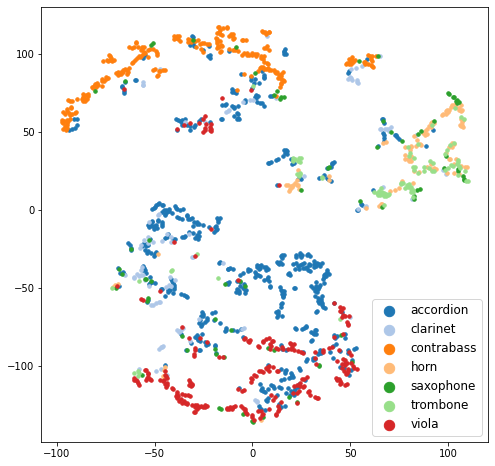

In [53]:
draw_tsne(unseen_tr_audio_embs, unseen_tr_labels, unseen_class_txt_list, dist='cosine')

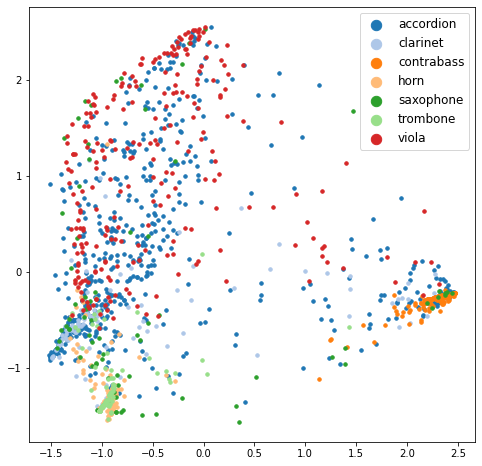

In [54]:
draw_pca(unseen_tr_audio_embs, unseen_tr_labels, unseen_class_txt_list)

In [69]:
org_word_embeddings = []
for word_idx in range(7):
    org_word_embeddings.append(seen_word_audio_dataset_tr.label_idx_to_word_emb_dict[word_idx])
for word_idx in range(7):
    org_word_embeddings.append(unseen_word_audio_dataset_tr.label_idx_to_word_emb_dict[word_idx])
org_word_embeddings = np.array(org_word_embeddings)

In [92]:
zsl_word_embeddings, zsl_word_classes = [], []
for word_idx in range(7):
    for k in range(len(seen_ts_labels)):
        if seen_ts_labels[k] == word_idx:
            zsl_word_embeddings.append(seen_ts_word_embs[k])
            zsl_word_classes.append(seen_class_txt_list[word_idx])
            break
for word_idx in range(7):
    for k in range(len(unseen_ts_labels)):
        if unseen_ts_labels[k] == word_idx:
            zsl_word_embeddings.append(unseen_ts_word_embs[k])
            zsl_word_classes.append(unseen_class_txt_list[word_idx])
            break
zsl_word_embeddings = np.array(zsl_word_embeddings)

In [84]:
zsl_word_embeddings.shape

(14, 128)

In [70]:
org_word_classes = seen_word_audio_dataset_tr.word_classes + unseen_word_audio_dataset_tr.word_classes

In [71]:
org_word_classes

['bassoon',
 'cello',
 'flute',
 'oboe',
 'trumpet',
 'tuba',
 'violin',
 'accordion',
 'clarinet',
 'contrabass',
 'horn',
 'saxophone',
 'trombone',
 'viola']

In [80]:
def draw_pca_with_class(_embs, _labels, _class_txt_list):
    pca = PCA(n_components=2)
    _pca_proj = pca.fit_transform(_embs)
    cmap = cm.get_cmap('tab20')
    fig, ax = plt.subplots(figsize=(8,8))
    for _i in range(len(_class_txt_list)):
        indices = [_j for _j in range(len(_labels)) if _labels[_j] == _i]
        ax.scatter(_pca_proj[indices, 0],
                   _pca_proj[indices, 1], 
                   c=np.array(cmap(_i)).reshape(1,4), 
                   label=_class_txt_list[_i],
                   s=12.0,
                   alpha=1.0
                  )
        ax.annotate(_class_txt_list[_i], (_pca_proj[indices, 0], _pca_proj[indices, 1]))
    plt.show()
    

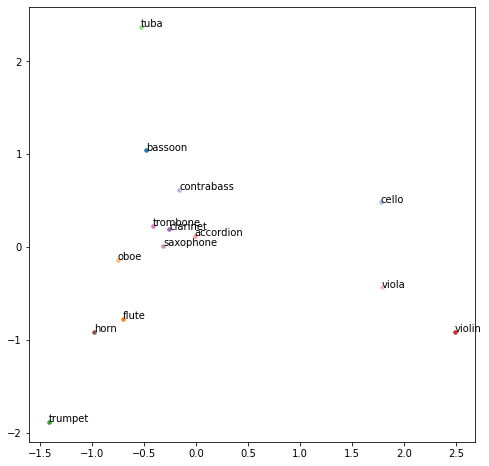

In [93]:
# zsl_word_embeddings
draw_pca_with_class(zsl_word_embeddings, list(range(14)), zsl_word_classes)

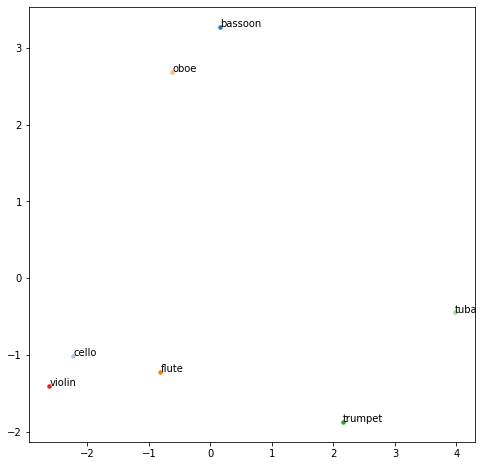

In [97]:
draw_pca_with_class(org_word_embeddings[:7], list(range(7)), org_word_classes[:7])

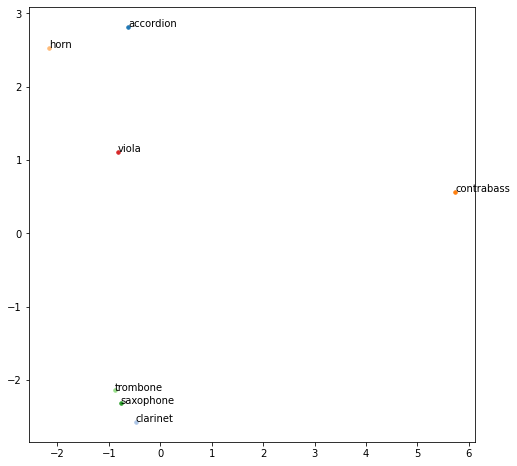

In [98]:
draw_pca_with_class(org_word_embeddings[7:], list(range(7)), org_word_classes[7:])

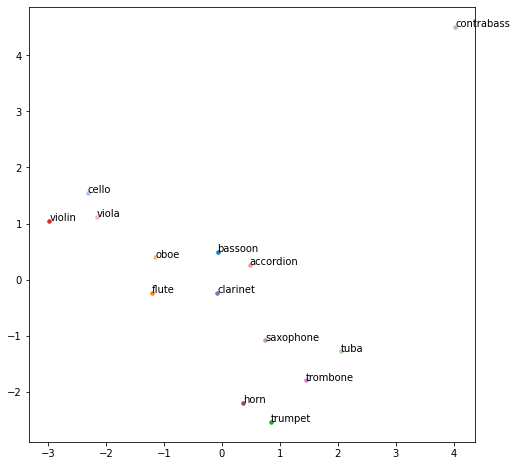

In [81]:
draw_pca_with_class(org_word_embeddings, list(range(14)), org_word_classes)

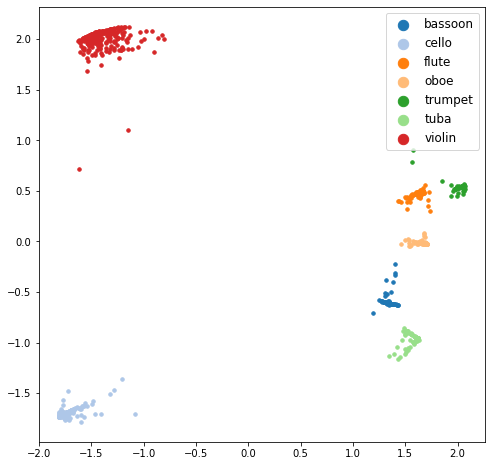

In [132]:
draw_pca(seen_tr_audio_embs, seen_tr_labels, seen_class_txt_list)

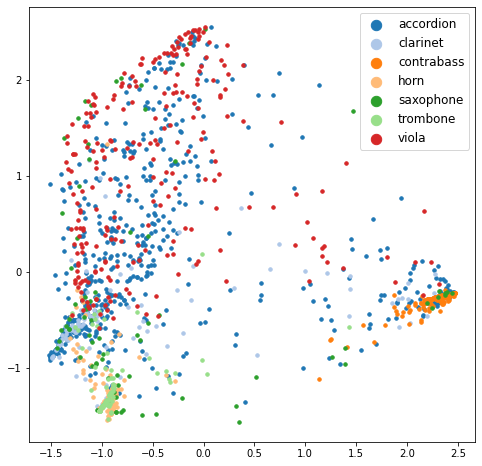

In [133]:
draw_pca(unseen_tr_audio_embs, unseen_tr_labels, unseen_class_txt_list)

### Generalized ZSL setting

In [99]:
seen_class_txt_list, unseen_class_txt_list

(['bassoon', 'cello', 'flute', 'oboe', 'trumpet', 'tuba', 'violin'],
 ['accordion',
  'clarinet',
  'contrabass',
  'horn',
  'saxophone',
  'trombone',
  'viola'])

In [100]:
added_unseen_tr_labels = [_n + 7 for _n in unseen_tr_labels]
added_unseen_ts_labels = [_n + 7 for _n in unseen_ts_labels]

In [101]:
all_tr_audio_embs = np.concatenate([seen_tr_audio_embs, unseen_tr_audio_embs])
all_tr_word_embs = np.concatenate([seen_tr_word_embs, unseen_tr_word_embs])

In [102]:
all_tr_labels = seen_tr_labels + added_unseen_tr_labels

In [103]:
all_tr_audio_embs.shape[0], all_tr_word_embs.shape[0], len(all_tr_labels)

(2330, 2330, 2330)

In [104]:
all_class_to_audio_embs, all_class_to_word_embs = defaultdict(list), defaultdict(list)
all_class_to_audio_seen_word_embs, all_class_to_word_seen_audio_embs = defaultdict(list), defaultdict(list)

for i in tqdm(range(all_tr_audio_embs.shape[0])):
    all_class_to_audio_embs[all_tr_labels[i]].append(all_tr_audio_embs[i])
    all_class_to_word_embs[all_tr_labels[i]].append(all_tr_word_embs[i])

    all_class_to_audio_seen_word_embs[all_tr_labels[i]].append(all_tr_audio_embs[i])
    all_class_to_word_seen_audio_embs[all_tr_labels[i]].append(all_tr_word_embs[i])
    
for i in range(seen_tr_audio_embs.shape[0]):
    all_class_to_audio_seen_word_embs[seen_tr_labels[i]].append(seen_tr_word_embs[i])
    all_class_to_word_seen_audio_embs[seen_tr_labels[i]].append(seen_tr_audio_embs[i])

for i in range(len(list(all_class_to_audio_embs.keys()))):
    print(i, len(all_class_to_audio_embs[i]), len(all_class_to_word_embs[i]), len(all_class_to_audio_seen_word_embs[i]), len(all_class_to_word_seen_audio_embs[i]))
    
all_class_to_mean_audio_emb, all_class_to_mean_word_emb = {}, {}
for _c in all_class_to_audio_embs:
    all_class_to_mean_audio_emb[_c] = np.mean(all_class_to_audio_embs[_c], axis=0)
    all_class_to_mean_word_emb[_c] = np.mean(all_class_to_word_embs[_c], axis=0)
    
all_class_to_mean_audio_seen_word_emb, all_class_to_mean_word_seen_audio_emb = {}, {}
for _c in all_class_to_audio_seen_word_embs:
    all_class_to_mean_audio_seen_word_emb[_c] = np.mean(all_class_to_audio_seen_word_embs[_c], axis=0)
    all_class_to_mean_word_seen_audio_emb[_c] = np.mean(all_class_to_word_seen_audio_embs[_c], axis=0)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 2330/2330 [00:00<00:00, 340323.45it/s]

0 100 100 200 200
1 232 232 464 464
2 96 96 192 192
3 84 84 168 168
4 76 76 152 152
5 88 88 176 176
6 228 228 456 456
7 551 551 551 551
8 100 100 100 100
9 247 247 247 247
10 108 108 108 108
11 80 80 80 80
12 92 92 92 92
13 248 248 248 248


In [105]:
all_class_txt_list = seen_class_txt_list + unseen_class_txt_list

In [106]:
all_class_txt_list

['bassoon',
 'cello',
 'flute',
 'oboe',
 'trumpet',
 'tuba',
 'violin',
 'accordion',
 'clarinet',
 'contrabass',
 'horn',
 'saxophone',
 'trombone',
 'viola']

In [107]:
all_class_to_mean_word_emb.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])

In [108]:
correct = 0
for idx in range(unseen_ts_audio_embs.shape[0]):
    curr_pred_idx, _ = nearest_neighbor_clf(np.expand_dims(unseen_ts_audio_embs[idx], 0), 
                                            all_class_to_mean_word_emb, 
                                            all_class_txt_list)
    if curr_pred_idx == added_unseen_ts_labels[idx]:
        correct += 1
print('Top-1 acc :', correct / unseen_ts_audio_embs.shape[0])

Top-1 acc : 0.011204481792717087


In [109]:
correct = 0
for idx in range(unseen_ts_audio_embs.shape[0]):
    curr_pred_indices, _ = nearest_neighbor_clf_k(np.expand_dims(unseen_ts_audio_embs[idx], 0), 
                                            all_class_to_mean_word_emb, 
                                            all_class_txt_list,
                                            3)
    if added_unseen_ts_labels[idx] in curr_pred_indices:
        correct += 1
print('Top-3 acc :', correct / unseen_ts_audio_embs.shape[0])

Top-3 acc : 0.41456582633053224


In [110]:
correct = 0
for idx in range(unseen_tr_audio_embs.shape[0]):
    curr_pred_idx, _ = nearest_neighbor_clf(np.expand_dims(unseen_tr_audio_embs[idx], 0), 
                                            all_class_to_mean_word_emb, 
                                            all_class_txt_list)
    if curr_pred_idx == added_unseen_tr_labels[idx]:
        correct += 1
print('Top-1 acc :', correct / unseen_tr_audio_embs.shape[0])

Top-1 acc : 0.016830294530154277


In [111]:
correct = 0
for idx in range(unseen_tr_audio_embs.shape[0]):
    curr_pred_indices, _ = nearest_neighbor_clf_k(np.expand_dims(unseen_tr_audio_embs[idx], 0), 
                                            all_class_to_mean_word_emb, 
                                            all_class_txt_list,
                                            3)
    if added_unseen_tr_labels[idx] in curr_pred_indices:
        correct += 1
print('Top-3 acc :', correct / unseen_tr_audio_embs.shape[0])

Top-3 acc : 0.3436185133239832


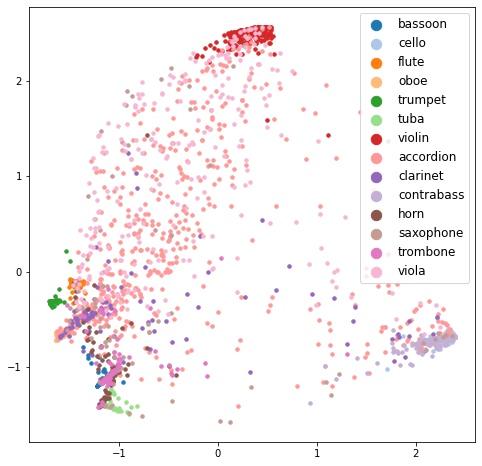

In [112]:
draw_pca(all_tr_audio_embs, all_tr_labels, all_class_txt_list)

/home/audio_dev/anaconda3/envs/jc_audio_dl/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/audio_dev/anaconda3/envs/jc_audio_dl/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/audio_dev/anaconda3/envs/jc_audio_dl/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


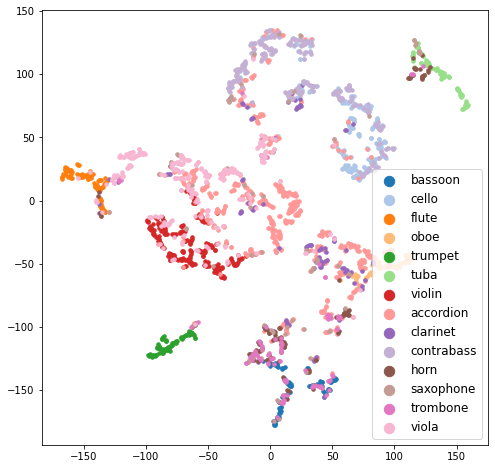

In [113]:
draw_tsne(all_tr_audio_embs, all_tr_labels, all_class_txt_list, dist='cosine')

We can examine that, in GZSL setup, it is pretty difficult to make correct prediction for unseen audio. This is because we are dealing with a very limited sized dataset. If we have a large number of seen classes that allows the model to learn the more detailed and complex relationship, it is expected to help the model to generalize much better to the unseen classes. 